In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
import umap
import seaborn as sns
from sklearn import preprocessing
from Subgraph import subgraph
%load_ext autoreload
%autoreload 2

<a href=#1 knns>1. compute correlation between embeddings of genes and their k-NNs</a>   
<a href=#2 sub>2. analyze the common neighbors for some gene pairs</a> 

<a id="knns"></a>
1. compute correlation between embeddings of genes and their k-NNs  
- select 5 top k-NNs for a node
- calculate 6 topological properties for each node and k-NNs  
- calculate Pearson Correlations between a node's topological property and its k-NNs'  
(part of this code is adapted from https://github.com/GemsLab/StrucEmbedding-GraphLibrary )

In [2]:
import sys  
sys.path.append('..')
sys.path.append('../link_prediction')

In [3]:
import networkx as nx
from link_prediction.utils_link_prediction import *

In [4]:
def load_emb(dataset, chrom):

    data_root = '/data/kezhang/PBC_dataset/nature_data/new_dataset/'
    split_path = data_root + dataset + '/splitting'

    name = 'observed_{}_{}_40000'.format(chrom, chrom)

    X = np.load('{}/{}_80.0_x.npy'.format(split_path, name))
    y = np.load('{}/{}_80.0_y.npy'.format(split_path, name))

    emb_path = data_root + dataset + '/embeddings'
    emb_file0 = 'mlp_GNN_GAT/{}_80.0_es16_nl1_nhds1_clf_mlp'.format(name)
    emb_hicoex = np.load('{}/{}.npy'.format(emb_path, emb_file0))

    emb_file1 = 'topological/{}_80.0'.format(name)
    emb_topology = np.load('{}/{}.npy'.format(emb_path, emb_file1))

    adj_hic = np.load('{}{}/chromatin_networks/{}_80.0.npy'.format(data_root, dataset, name))
    graph_hic = from_numpy_matrix(adj_hic)
    graph_hic = nx.convert_node_labels_to_integers(graph_hic)
    
    emb_hicoex_node = emb_hicoex[np.unique(X)]
    emb_topology_node = emb_topology[np.unique(X)]
    
    return graph_hic, emb_hicoex_node, emb_topology_node, X, y

In [5]:
def compute_centrality(graph_hic, X):
    betweeness_centrality = emb_topology_node[:,1]
    clustering_coeff = emb_topology_node[:,2]
    
    degree_cen = np.array(list(nx.degree_centrality(graph_hic).values()))
    degree_centrality = degree_cen[np.unique(X)]
    
    pagerank = np.array(list(nx.pagerank(graph_hic).values()))
    pagerank_node = pagerank[np.unique(X)]
    
    shortest_path_lengths = np.array(list(
            map(lambda e: nx.shortest_path_length(graph_hic, e[0], e[1]) if nx.has_path(graph_hic, e[0],
                                                                                        e[1]) else np.nan,
                X)))
    jaccard_index = np.array(list(map(lambda e: e[2], nx.jaccard_coefficient(graph_hic, X))))
    
    nan_idx = np.isnan(shortest_path_lengths)
    emb_topology_pair_shrt = shortest_path_lengths[~nan_idx]
    X_shrt = X[~nan_idx]
    shrt_node = []
    for i in np.unique(X_shrt):
        p = np.where(X_shrt==i)[0]
        shrt_node.append(np.sum(emb_topology_pair_shrt[p]))
        
    X_jacc = X
    jacc_node = []
    for i in np.unique(X_jacc):
        p = np.where(X_jacc==i)[0]
        jacc_node.append(np.sum(jaccard_index[p]))
       
    return (degree_centrality, betweeness_centrality, clustering_coeff, 
            pagerank_node, 
           shrt_node, jacc_node, X_shrt, X_jacc, jaccard_index)

In [6]:
def correlation(embedding, centrality, nodes, metric='euclidean', n_neighbors=5):
    from sklearn import metrics
    pairwise_distance = metrics.pairwise_distances(embedding, metric=metric)

    list_centrality = centrality    
    list_x, list_y = [], []
    for cur_node in range(0, len(nodes)):
        cur_sim_ranking = sorted(list(range(len(nodes))), key=lambda v: pairwise_distance[cur_node][v])[1:n_neighbors+1]
        list_y += [np.mean([list_centrality[i] for i in cur_sim_ranking])]
        list_x += [list_centrality[cur_node]]
    return np.corrcoef(list_x, list_y)[0,1]

In [7]:
dataset = 'breast_cancer'
chrom = '7'
graph_hic, emb_hicoex_node, emb_topology_node, X, y = load_emb(dataset, chrom)
centrality = compute_centrality(graph_hic, X)
degree_centrality, betweeness_centrality, clustering_coeff, pagerank_node, shrt_node, jacc_node, X_shrt, X_jacc, jaccard_index = centrality

In [8]:
print(len(y))
print(len(jaccard_index))

32824
32824


In [9]:
corr_deg = {}
corr_deg['euclidean'] = correlation(emb_hicoex_node, degree_centrality, np.unique(X), 'euclidean')
corr_deg['cosine'] = correlation(emb_hicoex_node, degree_centrality, np.unique(X), 'cosine')

corr_betw = {}
corr_betw['euclidean'] = correlation(emb_hicoex_node, betweeness_centrality, np.unique(X), 'euclidean')
corr_betw['cosine'] = correlation(emb_hicoex_node, betweeness_centrality, np.unique(X), 'cosine')

corr_clust = {}
corr_clust['euclidean'] = correlation(emb_hicoex_node, clustering_coeff, np.unique(X), 'euclidean')
corr_clust['cosine'] = correlation(emb_hicoex_node, clustering_coeff, np.unique(X), 'cosine')

corr_page = {}
corr_page['euclidean'] = correlation(emb_hicoex_node, pagerank_node, np.unique(X), 'euclidean')
corr_page['cosine'] = correlation(emb_hicoex_node, pagerank_node, np.unique(X), 'cosine')

corr_jacc = {}
corr_jacc['euclidean'] = correlation(emb_hicoex_node, jacc_node, np.unique(X_jacc), 'euclidean')
corr_jacc['cosine'] = correlation(emb_hicoex_node, jacc_node, np.unique(X_jacc), 'cosine')

corr_shrt = {}
corr_shrt['euclidean'] = correlation(emb_hicoex_node, shrt_node, np.unique(X_shrt), 'euclidean')
corr_shrt['cosine'] = correlation(emb_hicoex_node, shrt_node, np.unique(X_shrt),'cosine')

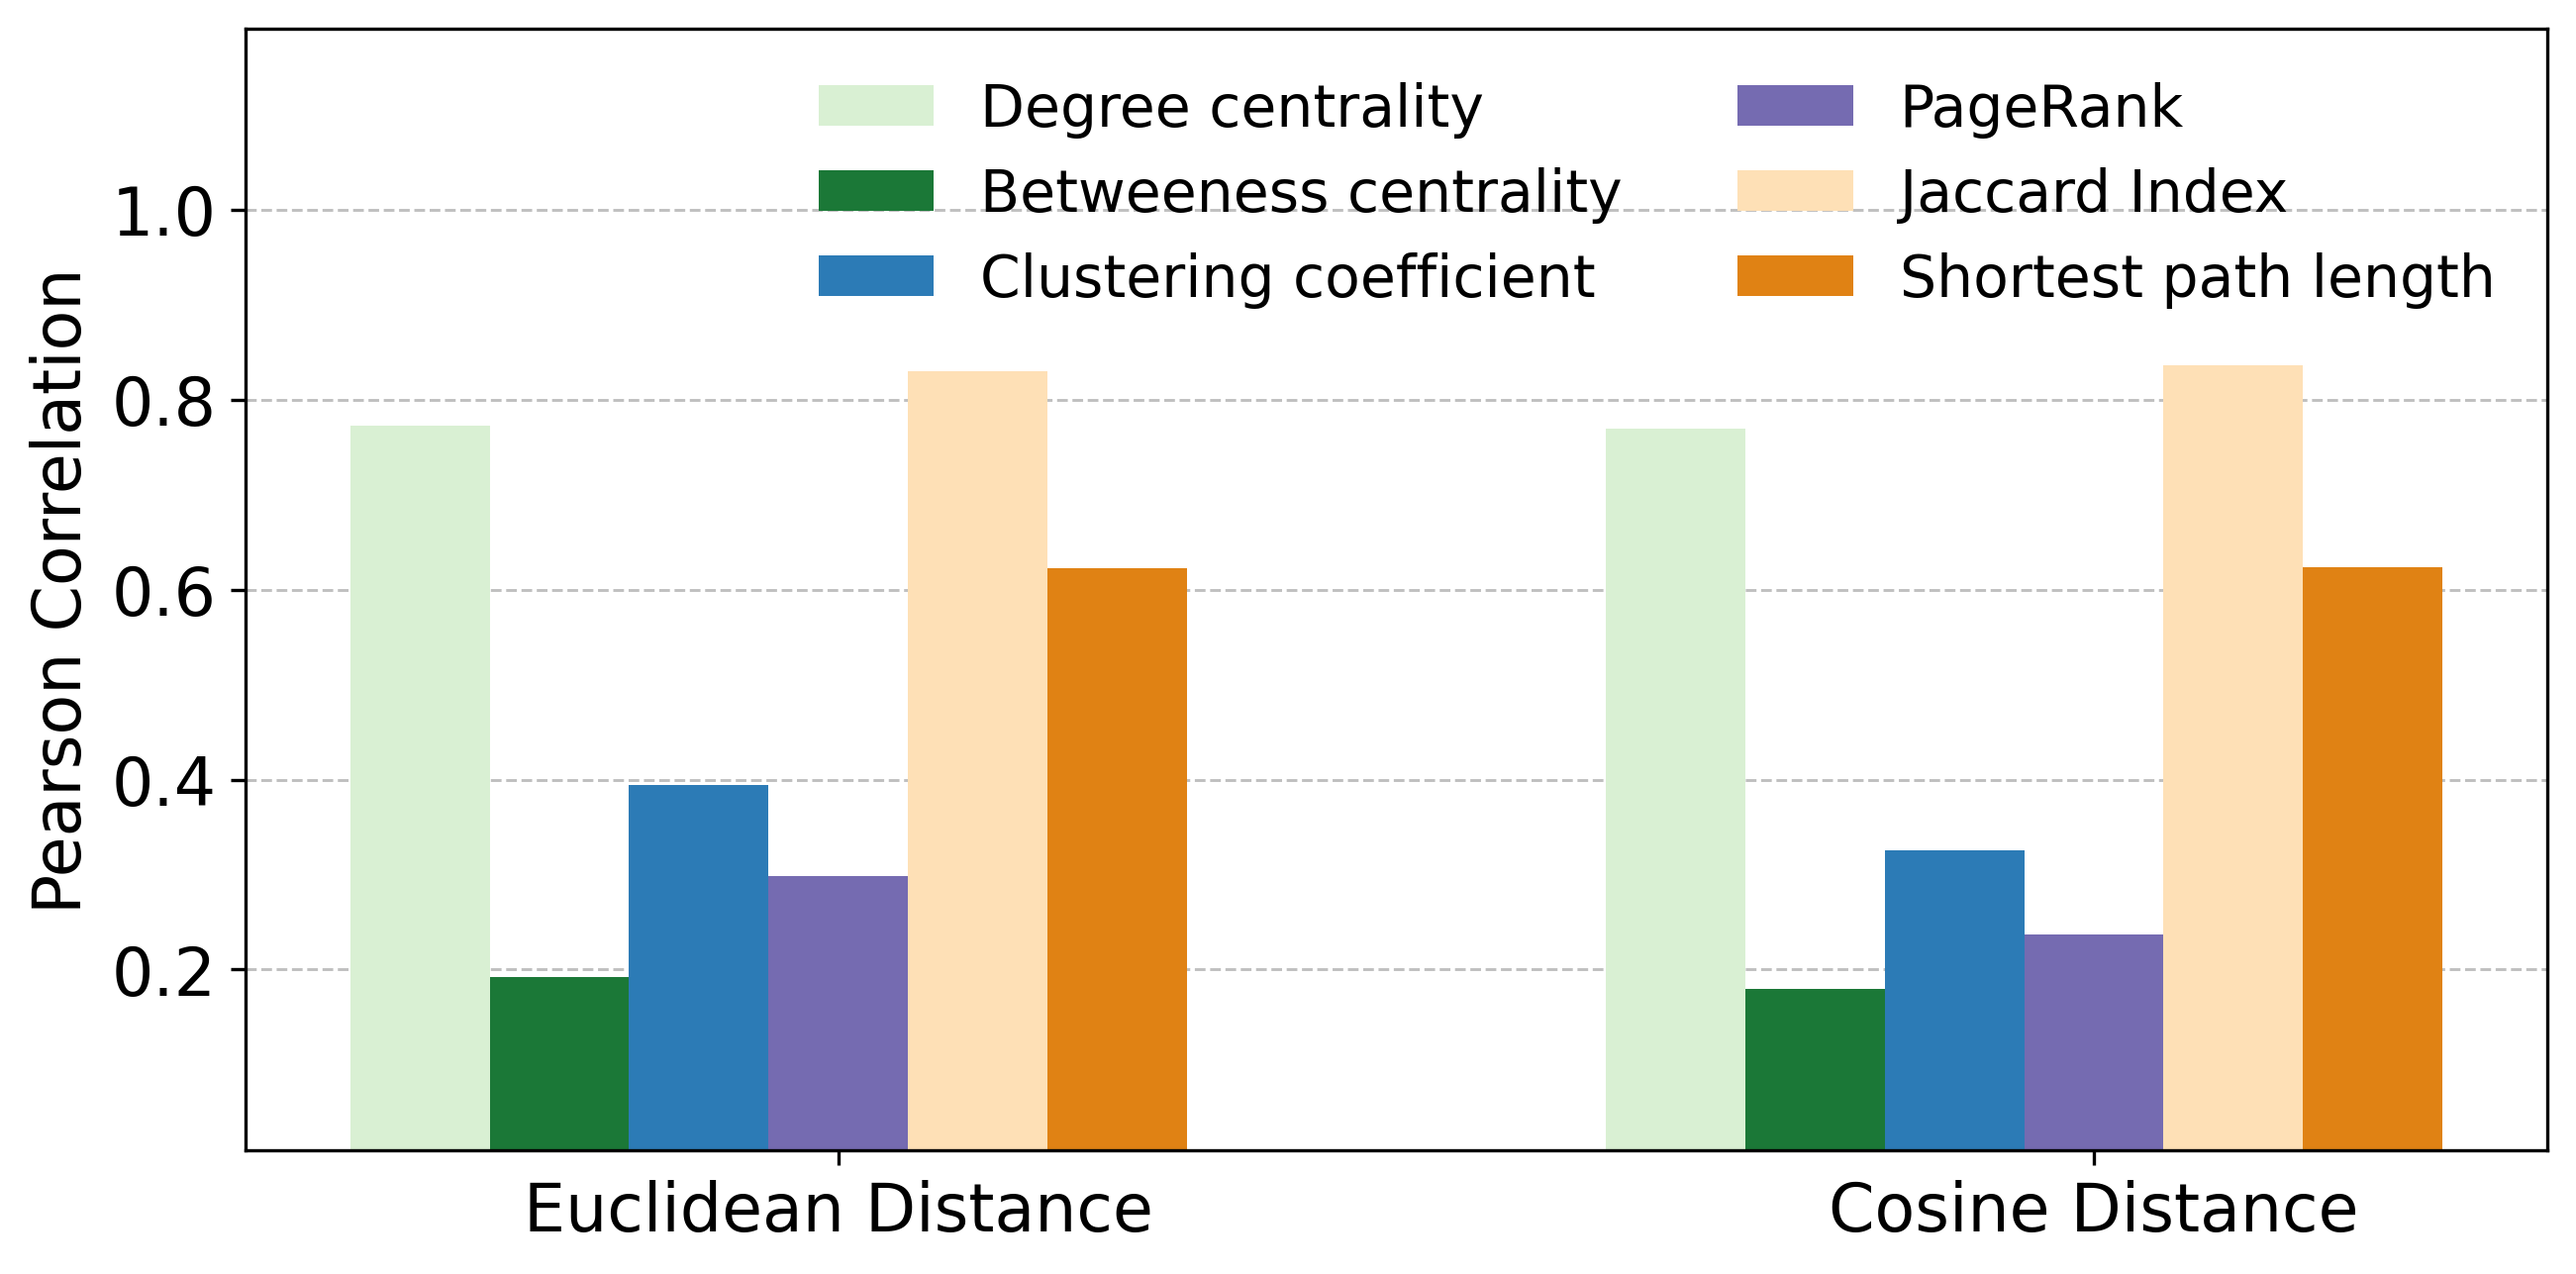

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10,5),dpi=300)
num = 2
total_width, n = 0.4, 6
width = total_width / n

pos_1 = [1+i*.6 for i in range(num)]
pos_2 = [p+width for p in pos_1]
pos_3 = [p+width for p in pos_2]
pos_4 = [p+width for p in pos_3]
pos_5 = [p+width for p in pos_4]
pos_6 = [p+width for p in pos_5]
ticks = (np.array(pos_1) + np.array(pos_2)) /2
    
ax.bar(pos_1, corr_deg.values(), width=width, label='Degree centrality', color='#d9f0d3', alpha=1)   # # #e08214
ax.bar(pos_2, corr_betw.values(), width=width, label='Betweeness centrality', color='#1b7837', alpha=1)
ax.bar(pos_3, corr_clust.values(), width=width, label='Clustering coefficient', color='#2C7BB6', alpha=1)
ax.bar(pos_4, corr_page.values(), width=width, label='PageRank', color='#756bb1', alpha=1)
ax.bar(pos_5, corr_jacc.values(), width=width, label='Jaccard Index', color='#fee0b6', alpha=1)
ax.bar(pos_6, corr_shrt.values(), width=width, label='Shortest path length', color='#e08214', alpha=1)
ax.grid(zorder=1, axis='y', ls='--', lw=.7, alpha = .8)
ax.set_axisbelow(True)
fsz = 16
label = ['Euclidean Distance', 'Cosine Distance']
plt.ylim((0.01, 1.19))
plt.tick_params(labelsize = fsz)
plt.xticks(ticks=pos_4, labels=label,fontsize=fsz)
plt.ylabel('Pearson Correlation',fontdict={'fontfamily':'sans-serif', 'fontsize': fsz})
plt.legend(loc='upper right', ncol=2, framealpha=0,fontsize=14)

# plt.title('Correlation between embeddings and topological properties of chrom {} on {}'.format(chrom, dataset))
# plt.savefig('Emb_correlation_{}_chr{}.jpg'.format(dataset, chrom),dpi=600)
# plt.savefig('Emb_correlation_{}_chr{}.eps'.format(dataset, chrom),dpi=600)
plt.show()

<a id="sub"></a>
2. analyze the common neighbors for some gene pairs
- select gene pairs, here we only consider gene pairs which are both contacted and co-expressed with each other
- get union subgraph for each gene pair
- find common neighbors for each gene pair  
- query enhancers from PatherDB (http://pantherdb.org/)
- count the co-expressed gene neighbors sharing enhancer (with both genes) 

In [12]:
def get_data(chrom, dataset):
    data_root = '/data/kezhang/PBC_dataset/nature_data/new_dataset/'
    name_coexp = 'coexpression_chr_{}_{}'.format(chrom, chrom)
    name_hic = 'observed_{}_{}_40000'.format(chrom, chrom)

    dataset = 'breast_cancer'
    mcf7_coexp = np.load('{}{}/coexpression_networks/{}_90.0.npy'.format(data_root, dataset, name_coexp))
    mcf7_hic = np.load('{}{}/chromatin_networks/{}_80.0.npy'.format(data_root, dataset, name_hic))
    degrees = np.nansum(mcf7_hic, axis=0)
    disconnected_nodes_mcf7 = np.ravel(np.argwhere(degrees == 0))
    mcf7_pairs = np.stack(np.where((mcf7_coexp == 1))).T

    mcf7_rna = pd.read_csv('{}/{}/rna/expression_info_chr_{}.csv'.format(data_root, dataset,chrom))

    mcf7_dico_pair, mcf7_dico_pairname = [], []
    for u,v in mcf7_pairs:
        if (u not in disconnected_nodes_mcf7) and (v not in disconnected_nodes_mcf7):
            mcf7_dico_pair.append([(u,v),(mcf7_rna.loc[u,'Gene name'], mcf7_rna.loc[v,'Gene name'])])

    mcf7_dif = pd.DataFrame(data=mcf7_dico_pair, columns=['u,v','name'])
    mcf7_dif.loc[:,'u_name'] = np.stack(mcf7_dif['name'])[:,0]
    mcf7_dif.loc[:,'v_name'] = np.stack(mcf7_dif['name'])[:,1]
    
    pair_list = mcf7_dif['u,v'].values
    r, c = np.stack(pair_list).T
    pair_list_11 = pair_list[(mcf7_hic[r,c] == 1) & (mcf7_coexp[r,c] == 1)]
    
    return pair_list_11, mcf7_rna, mcf7_hic, mcf7_coexp, mcf7_dif
#     return mcf10_rna, mcf10_hic, mcf10_coexp, mcf10_dif

In [13]:
def get_diffdata(chrom, mcf7_hic, mcf7_coep, mcf7_dif):
    pair_list = mcf7_dif['u,v'].values
    r, c = np.stack(pair_list).T
    pair_list_11 = pair_list[(mcf7_hic[r,c] == 1) & (mcf7_coexp[r,c] == 1)]
    return pair_list_11

In [14]:
def get_localdict(hic, pair_list):
    
    hic = np.triu(hic, 1)
    hic = hic + hic.T
    hic = np.nan_to_num(hic)
    graph = np.stack(np.where(hic > 0))
    
    pair_list = np.stack(pair_list_11)
    local_dict = {}
    for i in range(0, len(pair_list)):
        pair = pair_list[i,:]
        local_graph = subgraph(graph, pair)
#         ipdb.set_trace()
        idx = np.where((local_graph[0,:]==pair[0])|(local_graph[0,:]==pair[1]))[0]
        local_graph = local_graph[:,idx]
                
        local_dict[tuple(pair)] = local_graph.T
    return local_dict

In [15]:
def get_localnei(local_dict, pair_list_11, mcf7_rna, num_nei=5):
    shared_nodes = []
    for i in range(len(pair_list_11)):
        u,v = pair_list_11[i]
        neighbor_pairs = local_dict[(u,v)]
        n1 = neighbor_pairs[np.where(neighbor_pairs == pair_list_11[i][0])[0]]
        n2 = neighbor_pairs[np.where(neighbor_pairs == pair_list_11[i][1])[0]]
        s = np.intersect1d(n1,n2)
        shared_nodes.append(s[(s!=u)|(s!=v)].tolist())

    signifi_shared = [[i,s] for i,s in enumerate(shared_nodes) if len(s) >= num_nei]
    signifi_genes = [mcf7_rna.loc[s, 'Gene name'].values for s in shared_nodes if len(s) >= num_nei]
    return signifi_shared,signifi_genes

In [16]:
def shareE_analysis(chrom, signifi_shared, signifi_genes, pair_list_11, local_dict, mcf7_rna, mcf7_coexp, skip=False):
    mcf7_E_all = pd.read_excel('mcf7_chr'+chrom+'_pantherGeneList_all.xlsx', header=0)
    mcf7_E_all = mcf7_E_all.rename(columns={mcf7_E_all.columns[0]:'id', mcf7_E_all.columns[1]:'gene', 
                       mcf7_E_all.columns[2]:'name', mcf7_E_all.columns[3]:'enhancer'})
    
    mcf7_coexp_ = np.nan_to_num(mcf7_coexp)
    mcf7_coexp1 = mcf7_coexp_ + mcf7_coexp_.T
    
    shared_dict_all = {}  # all common neighbors, attention, and co-exp labels 
    share_dict = {}       # common neighbors in shared_dict_all
    share_dict_E = {}     # enhancers shared by neighbors and genes
    share_dict_gene = {}  # the set of all gene-neighbors that share same enhancer in share_dict_E with a gene or both two genes
    share_dict_itset = {}  # neighbor set that shared enhancers with both of two genes
    x1 = []
    y1 = []
    for i in range(len(signifi_shared)):
        (u,v) = pair_list_11[signifi_shared[i][0]]
        mask = np.isin(local_dict[(u,v)], signifi_shared[i][1])
        shared_dict = local_dict[(u,v)][mask[:,0]*mask[:,1]]

        u_name = mcf7_rna.loc[u, 'Gene name']
        v_name = mcf7_rna.loc[v, 'Gene name']
        
        # skip the gene pairs which already contact with same enhancers
        if skip:
            mcf7_E_uv = mcf7_E_all[mcf7_E_all['gene'].isin([u_name, v_name])]
            mcf7_E_uv.loc[:,'enhancer'] = mcf7_E_uv['enhancer'].astype(str)
            if len(mcf7_E_uv) < 2 or (mcf7_E_uv['enhancer'].isna()).sum() > 0:
                continue

            E_uv = [e.split(';') for e in mcf7_E_uv['enhancer']]
            E_count_uv = pd.value_counts(np.hstack(E_uv))
            if (E_count_uv==2).sum() > 0:
                continue
            
#         shared_dict_all[(u_name, v_name)] = shared_dict
        
        share_set = signifi_genes[i].tolist()
        
        mcf7_E0 = mcf7_E_all[mcf7_E_all['gene'].isin(share_set)]
        mcf7_E1 = mcf7_E0.loc[~mcf7_E0['enhancer'].isna()]
        mcf7_E1.loc[:,'enhancer'] = mcf7_E1['enhancer'].astype(str)
        
        E = [e.split(';') for e in mcf7_E1['enhancer']]
        if len(E) == 0:
            continue
        E_count = pd.value_counts(np.hstack(E))
        share_E = E_count[E_count>=2]      

        share_E1_u, share_E1_v = [],[]
        share_E1_geneu,share_E1_genev = [],[]
        for e in share_E.index.values:
            E_gene = mcf7_E1.loc[mcf7_E1['enhancer'].str.contains(e),'gene']
            if u_name in E_gene.tolist():
                share_E1_u.append(e)
                share_E1_geneu.append(E_gene.tolist())
            if v_name in E_gene.tolist():
                share_E1_v.append(e)
                share_E1_genev.append(E_gene.tolist())
        
        if len(share_E1_geneu) > 0 and len(share_E1_genev) > 0:
            share_E1_setu = np.unique(np.hstack(share_E1_geneu))
            share_E1_setv = np.unique(np.hstack(share_E1_genev))
            share_E1_setu = share_E1_setu[share_E1_setu != u_name]
            share_E1_setv = share_E1_setv[share_E1_setv != v_name]
            share_E1_uv = np.intersect1d(share_E1_setu, share_E1_setv)
            
            if len(share_E1_uv) > 0:
# #                 if only count the gene-neighbor pairs in which neighbors share E with both genes
#                 share_E1_u_ = [t for s,t in zip(share_E1_geneu,share_E1_u) if len(list(set(s).intersection(set(share_E1_uv))))>0]
#                 share_E1_v_ = [t for s,t in zip(share_E1_genev,share_E1_v) if len(list(set(s).intersection(set(share_E1_uv))))>0]         
#                 share_E1_geneu_ = [s for s in share_E1_geneu if len(list(set(s).intersection(set(share_E1_uv))))>0]
#                 share_E1_genev_ = [s for s in share_E1_genev if len(list(set(s).intersection(set(share_E1_uv))))>0]

                tmp = share_E1_u + share_E1_v
                tmp1 = share_E1_geneu + share_E1_genev
 
                share_set.remove(u_name)
                share_set.remove(v_name)    
                share_dict[(u_name,v_name)] = share_set
                share_dict_E[(u_name,v_name)] = tmp
                share_dict_gene[(u_name,v_name)] = tmp1
                share_dict_itset[(u_name,v_name)] = share_E1_uv

                # -------------statistical analysis--------------               
                j1 = mcf7_rna[mcf7_rna['Gene name'].isin(share_E1_uv)].index.values.tolist()
                j2 = mcf7_rna[mcf7_rna['Gene name'].isin(share_set)].index.values.tolist()
                i2_u = np.repeat(u, len(j2))
                i2_v = np.repeat(v, len(j2))
                i2_ = np.hstack((i2_u,i2_v))
                j2_ = np.tile(j2, 2)
                uv_coexp = mcf7_coexp1[i2_,j2_]
                uv_11_id = np.where(uv_coexp==1)[0]
                
                share_coexp = len(np.unique(j2_[uv_11_id]))
                share_E_coexp = len(np.intersect1d(np.unique(j2_[uv_11_id]), j1))
            
                if share_coexp > 0:
                    x1.append(share_E_coexp/share_coexp)


    share_all = (shared_dict_all, share_dict, share_dict_E, share_dict_gene, share_dict_itset)
    return share_all, x1, y1

count the ratio of co-expressed gene-neighbor pairs, central genes are included which share enhancers with each other, subgraphs for gene pairs in 'local_dict' can be output to visualization in Cytoscape

In [18]:
chrom = '3'
dataset = 'breast_cancer'
pair_list_11, mcf7_rna, mcf7_hic, mcf7_coexp, mcf7_dif = get_data(chrom, dataset)
local_dict = get_localdict(mcf7_hic, pair_list_11)
signifi_shared, signifi_genes = get_localnei(local_dict, pair_list_11, mcf7_rna)
share_all_3, x1_3, y1_3 = shareE_analysis(chrom, 
                                           signifi_shared, signifi_genes, 
                                           pair_list_11, local_dict, 
                                           mcf7_rna, mcf7_coexp, skip=False)

chrom = '4'
dataset = 'breast_cancer'
pair_list_11, mcf7_rna, mcf7_hic, mcf7_coexp, mcf7_dif = get_data(chrom, dataset)
local_dict = get_localdict(mcf7_hic, pair_list_11)
signifi_shared, signifi_genes = get_localnei(local_dict, pair_list_11, mcf7_rna)
share_all_4, x1_4, y1_4 = shareE_analysis(chrom, 
                                           signifi_shared, signifi_genes, 
                                           pair_list_11, local_dict, 
                                           mcf7_rna, mcf7_coexp, skip=False)

chrom = '7'
dataset = 'breast_cancer'
pair_list_11, mcf7_rna, mcf7_hic, mcf7_coexp, mcf7_dif = get_data(chrom, dataset)
local_dict = get_localdict(mcf7_hic, pair_list_11)
signifi_shared, signifi_genes = get_localnei(local_dict, pair_list_11, mcf7_rna)
share_all_7, x1_7, y1_7 = shareE_analysis(chrom, 
                                           signifi_shared, signifi_genes, 
                                           pair_list_11, local_dict, 
                                           mcf7_rna, mcf7_coexp, skip=False)

chrom = '10'
dataset = 'breast_cancer'
pair_list_11, mcf7_rna, mcf7_hic, mcf7_coexp, mcf7_dif = get_data(chrom, dataset)
local_dict = get_localdict(mcf7_hic, pair_list_11)
signifi_shared, signifi_genes = get_localnei(local_dict, pair_list_11, mcf7_rna)
share_all_10, x1_10, y1_10 = shareE_analysis(chrom, 
                                             signifi_shared, signifi_genes, 
                                             pair_list_11, local_dict, 
                                             mcf7_rna, mcf7_coexp, skip=False)

chrom = '22'
dataset = 'breast_cancer'
pair_list_11, mcf7_rna, mcf7_hic, mcf7_coexp, mcf7_dif = get_data(chrom, dataset)
local_dict = get_localdict(mcf7_hic, pair_list_11)
signifi_shared, signifi_genes = get_localnei(local_dict, pair_list_11, mcf7_rna)
share_all_22, x1_22, y1_22 = shareE_analysis(chrom, 
                                             signifi_shared, signifi_genes, 
                                             pair_list_11, local_dict, 
                                             mcf7_rna, mcf7_coexp, skip=False)

In [19]:
x1_all = [x1_3, x1_4, x1_7, x1_10, x1_22]

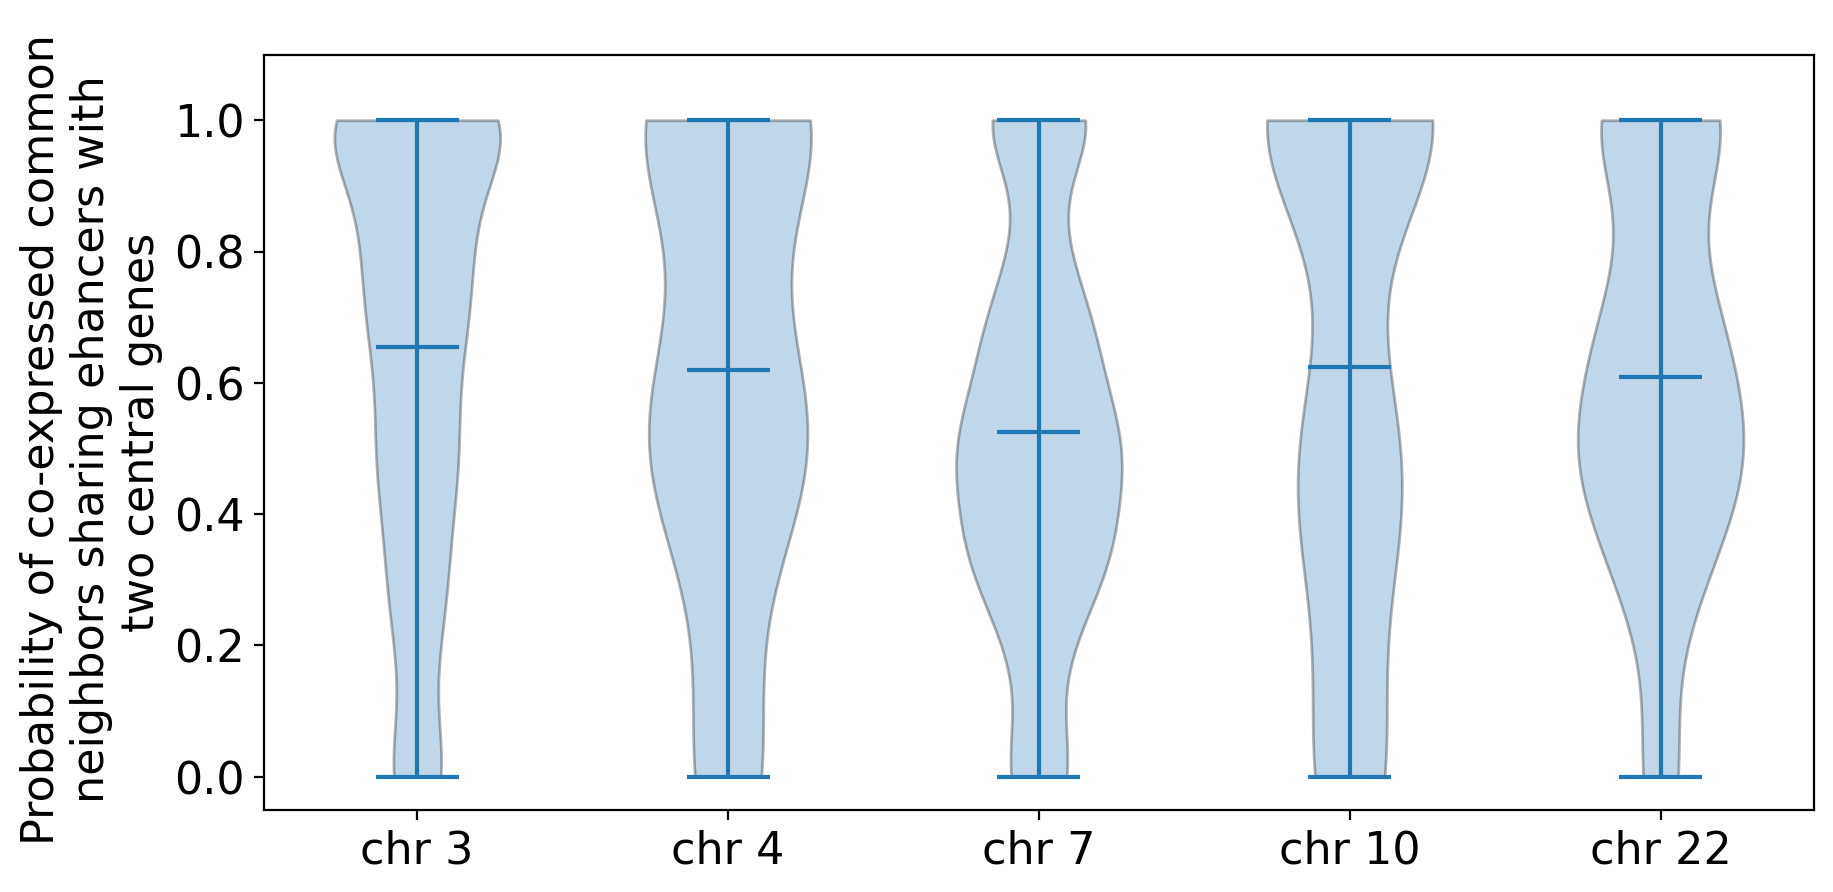

In [20]:
plt.figure(figsize=(10,5),dpi=200)
# num = 1 
num = len(x1_all) # the number of chrom for statistics

pos_1 = [1+i*1.5 for i in range(0,num)]
pos_2 = [p+1 for p in pos_1]
bp_share = plt.violinplot(x1_all, positions=pos_1[:num], widths=0.8, showmeans=True)#, showmedians=True

for pc in bp_share['bodies']:
    pc.set_facecolor('#2C7BB6')
    pc.set_edgecolor('black')
    

fsz = 16
plt.ylim((-0.05, 1.1))
plt.tick_params(labelsize = fsz)
ticks = pos_1
label=['chr 3', 'chr 4', 'chr 7', 'chr 10', 'chr 22']
plt.xticks(ticks=ticks, labels=label,fontsize=fsz)
plt.ylabel('Probability of co-expressed common \nneighbors sharing ehancers with \ntwo central genes',fontdict={'fontfamily':'sans-serif', 'fontsize': fsz})
# plt.title('Co-expressed gene-neighbor pairs on breast cancer',fontsize=fsz)
# plt.savefig('com_shareE.jpg',dpi=600)
plt.show()